# Importing stuff

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import mofr

In [3]:
import re
import string
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from tqdm import tqdm
import os
import random
from collections import defaultdict
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, confusion_matrix,
                             f1_score, precision_score,
                             recall_score, roc_auc_score)
from xgboost import XGBClassifier, plot_tree

import xgboost as xgb




In [4]:
seed=1234

# Loading data

In [5]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
sample_submission=pd.read_csv('sample_submission.csv')

In [6]:
train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [7]:
test

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [8]:
sample_submission

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


# Data exploration

In [9]:
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [10]:
train['keyword'].value_counts(dropna=False)

NaN                      61
fatalities               45
deluge                   42
armageddon               42
sinking                  41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 222, dtype: int64

In [11]:
train['location'].value_counts(dropna=False)[0:50]

NaN                  2533
USA                   104
New York               71
United States          50
London                 45
Canada                 29
Nigeria                28
UK                     27
Los Angeles, CA        26
India                  24
Mumbai                 22
Washington, DC         21
Kenya                  20
Worldwide              19
Chicago, IL            18
Australia              18
California             17
New York, NY           15
Everywhere             15
California, USA        15
San Francisco          14
United Kingdom         14
Florida                14
Indonesia              13
Washington, D.C.       13
Los Angeles            13
NYC                    12
Ireland                12
Toronto                12
Earth                  11
Seattle                11
Chicago                11
San Francisco, CA      11
London, England        10
Atlanta, GA            10
ss                     10
Sacramento, CA         10
New York City          10
Texas       

In [12]:
train.describe(include=['O'])

,keyword,location,text
count,7552,5080,7613
unique,221,3341,7503
top,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...
freq,45,104,10


# Data transformations


In [13]:
col_target='target'
col_exclude=[
'Id',
col_target
]

## Categorical transformations


In [14]:
import category_encoders as ce

In [15]:
# bayesian target encoding
encoder = ce.TargetEncoder(min_samples_leaf=1, smoothing=1.0)
encoder.fit_transform(train['keyword'], train[col_target])

train = pd.concat([train, encoder.transform(train['keyword']).add_prefix("BAYES_")], axis=1)
test = pd.concat([test, encoder.transform(test['keyword']).add_prefix("BAYES_")], axis=1)

## Text related transformations

In [16]:
train['text_len'] = train['text'].apply(lambda x: len(x.split(' ')))
train.head()

,id,keyword,location,text,target,BAYES_keyword,text_len
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0.688525,13
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0.688525,7
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,0.688525,22
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,0.688525,9
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,0.688525,17


In [17]:
test['text_len'] = test['text'].apply(lambda x: len(x.split(' ')))
test.head()

,id,keyword,location,text,BAYES_keyword,text_len
0,0,NaN,NaN,Just happened a terrible car crash,0.688525,6
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",0.688525,9
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",0.688525,19
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,0.688525,4
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,0.688525,8


In [18]:
max(train['text_len'])

54

In [19]:
train

,id,keyword,location,text,target,BAYES_keyword,text_len
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0.688525,13
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0.688525,7
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,0.688525,22
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,0.688525,9
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,0.688525,17
...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,0.688525,11
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,0.688525,20
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,0.688525,8
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,0.688525,19


### Text cleaning

In [20]:
# Special thanks to https://www.kaggle.com/tanulsingh077 for this function
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [21]:
train['text_clean']=(train['location'].fillna('')+' '+train['text']).apply(clean_text)
# train['text_clean'] = train['text'].apply(clean_text)
train.head()

,id,keyword,location,text,target,BAYES_keyword,text_len,text_clean
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0.688525,13,our deeds are the reason of this earthquake m...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0.688525,7,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,0.688525,22,all residents asked to shelter in place are b...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,0.688525,9,people receive wildfires evacuation orders i...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,0.688525,17,just got sent this photo from ruby alaska as ...


In [22]:
test['text_clean']=(test['location'].fillna('')+' '+test['text']).apply(clean_text)
# test['text_clean'] = test['text'].apply(clean_text)
test.head()

,id,keyword,location,text,BAYES_keyword,text_len,text_clean
0,0,NaN,NaN,Just happened a terrible car crash,0.688525,6,just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",0.688525,9,heard about earthquake is different cities st...
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",0.688525,19,there is a forest fire at spot pond geese are...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,0.688525,4,apocalypse lighting spokane wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,0.688525,8,typhoon soudelor kills in china and taiwan


#### Stop words

In [23]:
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text
    
train['text_clean'] = train['text_clean'].apply(remove_stopwords)
train.head()

test['text_clean'] = test['text_clean'].apply(remove_stopwords)
test.head()

,id,keyword,location,text,BAYES_keyword,text_len,text_clean
0,0,NaN,NaN,Just happened a terrible car crash,0.688525,6,happened terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",0.688525,9,heard earthquake different cities stay safe e...
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",0.688525,19,forest fire spot pond geese fleeing across st...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,0.688525,4,apocalypse lighting spokane wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,0.688525,8,typhoon soudelor kills china taiwan


#### Stemming

In [24]:
stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [25]:
train['text_clean'] = train['text_clean'].apply(stemm_text)
train.head()

test['text_clean'] = test['text_clean'].apply(stemm_text)
test.head()

,id,keyword,location,text,BAYES_keyword,text_len,text_clean
0,0,NaN,NaN,Just happened a terrible car crash,0.688525,6,happen terribl car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",0.688525,9,heard earthquak differ citi stay safe everyon
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",0.688525,19,forest fire spot pond gees flee across street...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,0.688525,4,apocalyps light spokan wildfir
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,0.688525,8,typhoon soudelor kill china taiwan


## Wordclouds

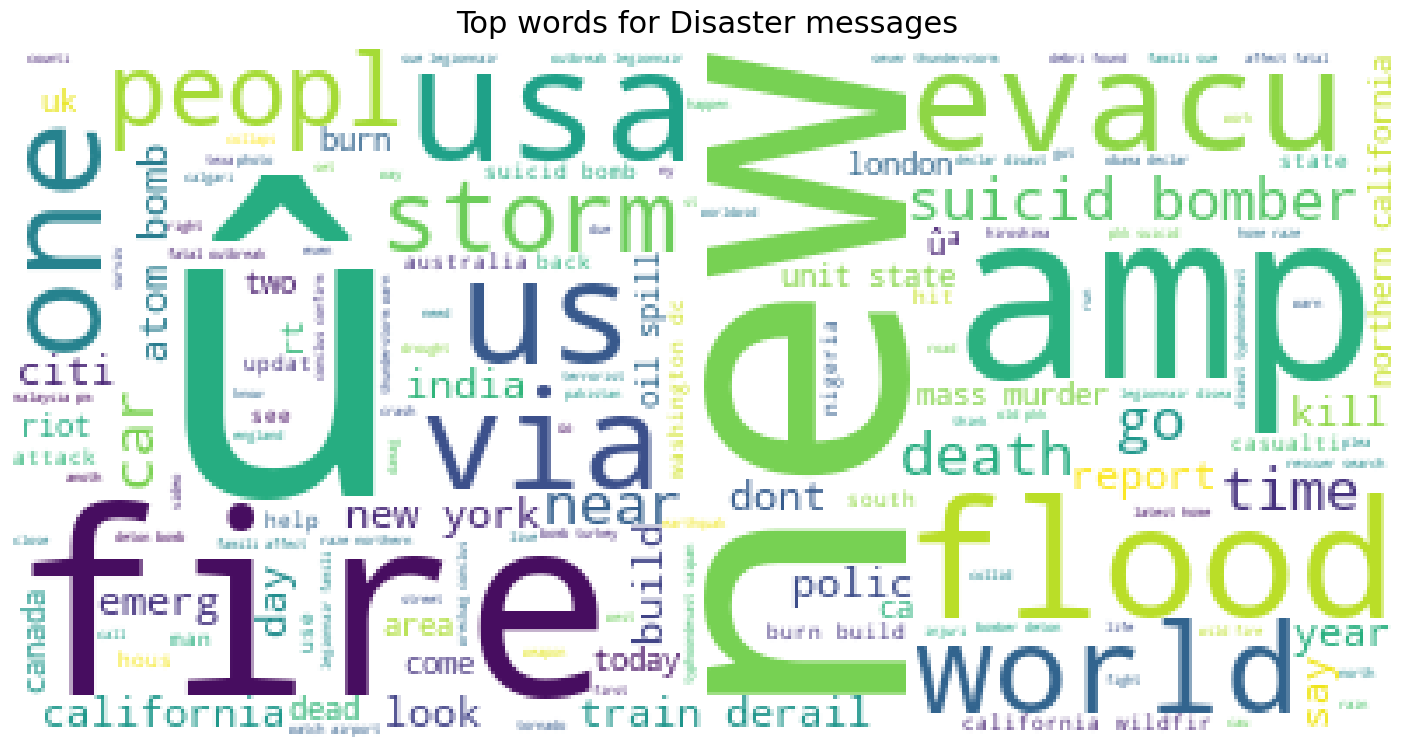

In [26]:
wc = WordCloud(
    background_color='white', 
    max_words=200, 
)
wc.generate(' '.join(text for text in train.loc[train['target'] == 1, 'text_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words for Disaster messages', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

## Vectorization

In [27]:
# how to define X and y (from the SMS data) for use with COUNTVECTORIZER
x = train['text_clean']
y = train[col_target]

print(len(x), len(y))

7613 7613


In [28]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

6090 6090
1523 1523


In [29]:
from sklearn.feature_extraction.text import CountVectorizer

# instantiate the vectorizer
vect = CountVectorizer()
vect.fit(X_train)

CountVectorizer()

In [30]:
# Use the trained to create a document-term matrix from train and test sets
X_train_dtm = vect.transform(X_train)
X_test_dtm = vect.transform(X_test)
test_dtm = vect.transform(test['text_clean'])

In [31]:
vect_tunned = CountVectorizer(stop_words='english', ngram_range=(1), min_df=0.1, max_df=0.7, max_features=200)

In [32]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()

tfidf_transformer.fit(X_train_dtm)
X_train_tfidf = tfidf_transformer.transform(X_train_dtm)

X_train_tfidf

<6090x13245 sparse matrix of type '<class 'numpy.float64'>'
	with 59757 stored elements in Compressed Sparse Row format>

In [33]:
X_test_tfidf = tfidf_transformer.transform(X_test_dtm)

In [34]:
test_tfidf = tfidf_transformer.transform(test_dtm)

# Modelling

## XGBoost simple

In [35]:
from sklearn.pipeline import Pipeline

xgb_model = Pipeline([
    ('bow', CountVectorizer()), 
    ('tfid', TfidfTransformer()),  
    ('model', xgb.XGBClassifier(
        learning_rate=0.1,
        max_depth=8,
        n_estimators=100,
        use_label_encoder=False,
        eval_metric='auc',
        # colsample_bytree=0.8,
        # subsample=0.7,
        # min_child_weight=5,
    ))
])

Train accuracy: 0.8231527093596059
Test accuracy: 0.7531188443860801


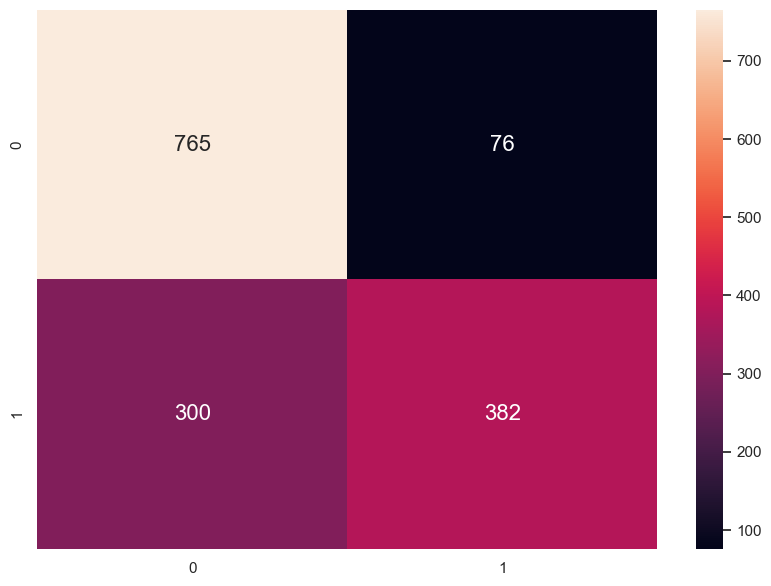

In [36]:
# Fit the pipeline with the data
xgb_model.fit(X_train, y_train)

y_pred_class = xgb_model.predict(X_test)
y_pred_train = xgb_model.predict(X_train)

print('Train accuracy: {}'.format(accuracy_score(y_train, y_pred_train)))
print('Test accuracy: {}'.format(accuracy_score(y_test, y_pred_class)))

array=confusion_matrix(y_test, y_pred_class)

df_cm = pd.DataFrame(array, range(2), range(2))
plt.figure(figsize=(10,7))
sns.set(font_scale=1.) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size

plt.show()

In [37]:
X_train['XGB_SCORE']=xgb_model.predict_proba(X_train)[:, 1]
X_test['XGB_SCORE']=xgb_model.predict_proba(X_test)[:, 1]

In [38]:
print('The Lift on the train set is: '+ str(mofr.metrics.lift(y_train, X_train['XGB_SCORE'])))
print('The gini on the train set is: '+ str(mofr.metrics.gini(y_train.apply(int), X_train['XGB_SCORE'])))
# print('The accuracy on the train set is: '+ str(mofr.metrics.accuracy_score(train[col_target].apply(int), train['XGB_SCORE'].apply(lambda x: int(x>0.5)))))
print('\n')
print('The Lift on the valid set is: '+ str(mofr.metrics.lift(y_test, X_test['XGB_SCORE'])))
print('The gini on the valid set is: '+ str(mofr.metrics.gini(y_test.apply(int), X_test['XGB_SCORE'])))
# print('The accuracy on the valid set is: '+ str(mofr.metrics.accuracy_score(df[valid_mask][col_target].apply(int), df[valid_mask]['XGB_SCORE'].apply(lambda x: int(x>0.5)))))
print('\n')

The Lift on the train set is: 2.3522595596755504
The gini on the train set is: 0.8136833166576365


The Lift on the valid set is: 2.1309681252755257
The gini on the valid set is: 0.6778709189241965




## Naive Bayes

In [39]:
# Create a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

# Train the model
nb.fit(X_train_dtm, y_train)

MultinomialNB()

In [40]:
# Make class anf probability predictions
y_pred_class = nb.predict(X_test_dtm)
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]

0.7951411687458962


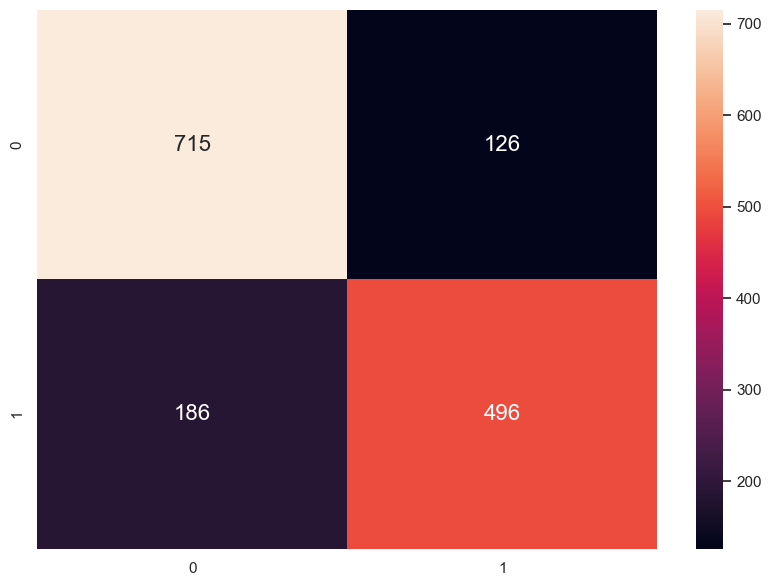

In [41]:
print(accuracy_score(y_test, y_pred_class))

array=confusion_matrix(y_test, y_pred_class)

df_cm = pd.DataFrame(array, range(2), range(2))
plt.figure(figsize=(10,7))
sns.set(font_scale=1.) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size

plt.show()

In [42]:
X_train['NB_SCORE']=nb.predict_proba(X_train_dtm)[:, 1]
X_test['NB_SCORE']=nb.predict_proba(X_test_dtm)[:, 1]

In [43]:
print('The Lift on the train set is: '+ str(mofr.metrics.lift(y_train, X_train['NB_SCORE'])))
print('The gini on the train set is: '+ str(mofr.metrics.gini(y_train.apply(int), X_train['NB_SCORE'])))
print('The accuracy on the train set is: '+ str(mofr.metrics.accuracy_score(y_train.apply(int), X_train['NB_SCORE']>0.5)))
print('\n')
print('The Lift on the valid set is: '+ str(mofr.metrics.lift(y_test, X_test['NB_SCORE'])))
print('The gini on the valid set is: '+ str(mofr.metrics.gini(y_test.apply(int), X_test['NB_SCORE'])))
print('The accuracy on the valid set is: '+ str(mofr.metrics.accuracy_score(y_test.apply(int), X_test['NB_SCORE']>0.5)))
print('\n')

The Lift on the train set is: 2.3483970645036694
The gini on the train set is: 0.9285236497567491
The accuracy on the train set is: 0.9134646962233169


The Lift on the valid set is: 2.218542157821095
The gini on the valid set is: 0.7048653850847859
The accuracy on the valid set is: 0.7951411687458962




## LSTM

In [44]:
# import keras
# from keras.models import Sequential
# from keras.initializers import Constant
# from keras.layers import (LSTM, 
#                           Embedding, 
#                           BatchNormalization,
#                           Dense, 
#                           TimeDistributed, 
#                           Dropout, 
#                           Bidirectional,
#                           Flatten, 
#                           GlobalMaxPool1D)
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
# from keras.layers.embeddings import Embedding
# from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
# from keras.optimizers import Adam


In [45]:
# texts = train['text_clean']
# target = train['target']

In [46]:
# # Calculate the length of our vocabulary
# word_tokenizer = Tokenizer()
# word_tokenizer.fit_on_texts(texts)

# vocab_length = len(word_tokenizer.word_index) + 1
# vocab_length

# Scoring the test set

In [51]:
test['target']=nb.predict(test_dtm)

ValueError: Length of values (8) does not match length of index (3263)

In [48]:
submission=test[['id','target']]

In [49]:
submission.to_csv('submission.csv', index=False)